In [4]:
import sys; sys.path.append('..')
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from src.utils.metrics import (
    compute_average_accuracy,
    compute_forgetting_measure,
    compute_learning_curve_area,
    compute_ausuc,
    compute_ausuc_matrix,
    compute_individual_accs_matrix,
    compute_task_transfer_matrix,
    compute_seen_classes_acc_history,
    compute_unseen_classes_acc_history,
    compute_joined_ausuc_history,
    compute_acc_for_classes,
    compute_cross_entropy_for_task
)

In [12]:
import collections
from typing import Dict, List

from firelab.config import Config
import pandas as pd
from tqdm import tqdm

def get_exp_args(config: Config):
    short_name_to_name = {
        #'model_type': 'hp.head.model_type',
        'model_type': 'hp.head.model_type',
        #'seed': 'random_seed',
#         'lr': 'hp.optim.groups.head.lr',
#         'fake_clf_coef': 'hp.fake_clf.loss_coef',
#         'pull_goldens_coef': 'hp.pull_golden_protos.loss_coef',
#         'after_fuse_identity_init': 'hp.head.deep.after_fuse_transform.identity_init',
#         'num_prototypes': 'hp.head.common.num_prototypes',
#         'noise': 'hp.head.common.noise.std',
#         'noise_layers': 'hp.head.common.noise.transform_layers',
#         'attrs_layers': 'hp.head.common.attrs_transform.layers',
#         'seed': 'random_seed'
    }
    
    return {short_name: config.get(name) for short_name, name in short_name_to_name.items()}


def get_exp_shortname(config: Config):
    return ' '.join([f'[{k}: {v}]' for k, v in get_exp_args(config).items()])


def find_exps(experiments_dir: os.PathLike) -> Dict[str, List[str]]:
    """
    Returns dictionary, where a key is a shortname of the experiment
    and the value is the list of different runs (grouped by shortname)
    """
    experiments_dirs = [os.path.join(experiments_dir, e) for e in os.listdir(experiments_dir)]
    configs = [Config.load(os.path.join(e, 'config.yml')) for e in tqdm(experiments_dirs, desc='Loading configs')]
    shortnames = [get_exp_shortname(c) for c in configs]
    
    result = collections.defaultdict(list)
    for e, name in zip(experiments_dirs, shortnames):
        result[name].append(e)

    return dict(result)

In [13]:
dataset = 'AwA'
# experiments_dir = '/ibex/scratch/skoroki/experiments/deep_model'
# baseline_dir = '/ibex/scratch/skoroki/experiments/baseline'
experiments_dir = '../experiments-cub'

exps = find_exps(experiments_dir)
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/logits_history.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/targets.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/class_splits.npy')] for m in exps}
exps = {m: exps[m] for m in exps if len(exps[m]) > 0}
# exps = {'baseline': [os.path.join(baseline_dir, e) for e in os.listdir(baseline_dir) if not e.endswith('5-00001')], **exps}
methods = list(exps.keys())

# knn_logits_histories = {m: [np.load(f'{e}/custom_data/knn_logits_history.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading logits histories') if m != 'baseline'}
# golden_logits_histories = {m: [np.load(f'{e}/custom_data/golden_logits_history.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading logits histories') if m != 'baseline'}
logits_histories = {m: [np.load(f'{e}/custom_data/logits_history.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading logits histories')}
targets = {m: [np.load(f'{e}/custom_data/targets.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading targets')}
class_splits = {m: [np.load(f'{e}/custom_data/class_splits.npy', allow_pickle=True) for e in exps[m]] for m in tqdm(exps, desc='Loading class splits')}
configs = {m: [Config.load(f'{e}/config.yml') for e in exps[m]] for m in tqdm(exps, desc='Loading configs')}

Loading configs: 100%|██████████| 2/2 [00:00<00:00, 74.91it/s]


In [14]:
# old_exp_names = list(exps.keys())
# new_logits_histories = {'baseline': logits_histories['baseline']}
# new_targets = {'baseline': targets['baseline']}
# new_class_splits = {'baseline': class_splits['baseline']}
# new_configs = {'baseline': configs['baseline']}

# for e in old_exp_names:
#     if e == 'baseline': continue
#     for prefix, src_logits in [('average generations', logits_histories),  ('nearest neighbour', knn_logits_histories), ('golden prototypes', golden_logits_histories)]:
#         new_logits_histories[f'[{prefix}] {e}'] = src_logits[e]
#         new_targets[f'[{prefix}] {e}'] = targets[e]
#         new_class_splits[f'[{prefix}] {e}'] = class_splits[e]

In [15]:
from src.utils.data_utils import construct_output_mask
from src.utils.metrics import remap_targets
from typing import List
import torch
import torch.nn.functional as F


def get_labels(methods):
    if isinstance(methods, list):
        return methods
    else:
        return methods.values()
    
    
def get_num_runs(methods):
    return [len(targets[m]) for m in methods]


def compute_harmonic(method: str, restrict_space: bool):
    values_unseen = [compute_unseen_classes_acc_history(l[:-1], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_seen = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values = [2 * u[1:] * s[:-1] / (u[1:] + s[:-1]) for u, s in zip(np.array(values_unseen), np.array(values_seen))]
    values_avg = np.array(values).mean(0) * 100
    
    return values_avg


def compute_unseen_accs(method: str, restrict_space: bool):
    values = [compute_unseen_classes_acc_history(l[:-1], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
    return np.array(values).mean(0) * 100


def compute_seen_accs(method: str, restrict_space: bool):
    values = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
    return np.array(values).mean(0) * 100


def compute_joint_acc(method: str):
    values = [(l[1:].argmax(axis=2) == t.reshape(1, -1)).mean(1) for l, t in zip(logits_histories[method], targets[method])]
    
    return np.array(values).mean(0) * 100


def compute_ausucs(method: str):
    values = [[compute_ausuc(l, t, construct_output_mask(c[:n_tasks_learned], len(l[0]))) for n_tasks_learned, l in enumerate(l_hist)] \
                for l_hist, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
    return np.array(values).mean(0)


def compute_average_taskwise_accucy(logits_history, targets, class_splits):
    assert len(logits_history) == len(class_splits) + 1
    
    acc_matrix = compute_individual_accs_matrix(logits_history[1:], targets, class_splits)
    acc_matrix = np.tril(acc_matrix)
    accs = acc_matrix.sum(axis=1) / np.arange(1, len(class_splits) + 1)
    
    return accs


def compute_immediate_accuracy(method, restrict_space: bool=True):
    acc_matrices = [compute_individual_accs_matrix(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    accs = [np.diag(acc_matrix) for acc_matrix in acc_matrices]
    
    return np.array(accs).mean(0)


def compute_forgetting(method: str):
    acc_matrices = [compute_individual_accs_matrix(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values = [[compute_forgetting_measure(accs, i) for i in range(1, len(accs))] for accs in acc_matrices]
    
    return np.array(values).mean(0)
    

def compute_clf_loss(method: str):
    values = [[compute_cross_entropy_for_task(l, t, c) for l, c in zip(logits_hist[1:], classes) ] for logits_hist, t, classes in zip(logits_histories[method], targets[method], class_splits[method])]
    
    return np.array(values).mean(0)

def plot_methods_values(values, labels: List[str], num_runs: List[int], measure: str, dataset: str, task_ticks=None):
    plt.figure(figsize=(15, 7))
    plt.title(f'[{dataset}] {measure}')
    
    task_ticks = task_ticks or np.arange(len(values[0])) + 1

    for vals, label, n_runs in zip(values, labels, num_runs):
        #kwargs = {'lineStyle': '--'} if 'true' in method else {}
        kwargs = {}
        plt.plot(task_ticks, vals, label=f'{label} (final: {vals[-1]: .3f}, mean: {vals.mean(): .3f}, num_runs: {n_runs})', **kwargs)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    # plt.legend()
    plt.xlabel('Task')
    plt.ylabel(measure)
    plt.xticks(task_ticks)
    plt.grid()


def plot_seen_acc(methods, restrict_space: bool=False):
    plot_methods_values([compute_seen_accs(m, restrict_space) for m in methods],
        get_labels(methods), get_num_runs(methods),
        f'Accuracy on seen classes (restrict space: {restrict_space})', dataset)


def plot_unseen_acc(methods, restrict_space: bool=False):
    plot_methods_values([compute_unseen_accs(m, restrict_space) for m in methods],
        get_labels(methods), get_num_runs(methods),
        f'Accuracy on unseen classes (restrict space: {restrict_space})', dataset)
    
    
def plot_harmonics(methods, restrict_space: bool=False):
    plot_methods_values([compute_harmonic(m, restrict_space) for m in methods],
        get_labels(methods), get_num_runs(methods),
        f'Harmonic on seen/unseen classes (restrict space: {restrict_space})', dataset)
    
    
def plot_joint(methods):
    plot_methods_values([compute_joint_acc(m) for m in methods],
        get_labels(methods), get_num_runs(methods),
        f'Joint accuracy', dataset)
    
    
def plot_ausucs(methods):
    plot_methods_values([compute_ausucs(m) for m in methods], 
        get_labels(methods), get_num_runs(methods),
        f'Continual AUSUC', dataset)
    

def plot_forgetting(methods):
    plot_methods_values([compute_forgetting(m) for m in methods],
        get_labels(methods), get_num_runs(methods),
        'Forgetting', dataset)
    
    
def plot_immediate_accs(methods, restrict_space: bool=True):
    plot_methods_values([compute_immediate_accuracy(m, restrict_space=restrict_space) for m in methods],
        get_labels(methods), get_num_runs(methods),
        f'Immediate accuracy (restrict_space: {restrict_space})', dataset)
    
    
def plot_clf_loss(methods, restrict_space: bool=True):
    plot_methods_values([compute_clf_loss(m) for m in methods],
        get_labels(methods), get_num_runs(methods),
        f'Classification loss on task $t$ after task $t$ (restrict_space: {restrict_space})', dataset)
    
    
def get_exps_for_a_group(exps, configs, group):
    result = {}
    
    for exp_shortname, exp_paths in exps.items():
        config = configs[exp_shortname][0]
        
        if all(config.get(k) == v for k, v in group.items()):
            result[exp_shortname] = exp_paths
    
    result = {k: result[k] for k in sorted(result.keys())}
    
    return result

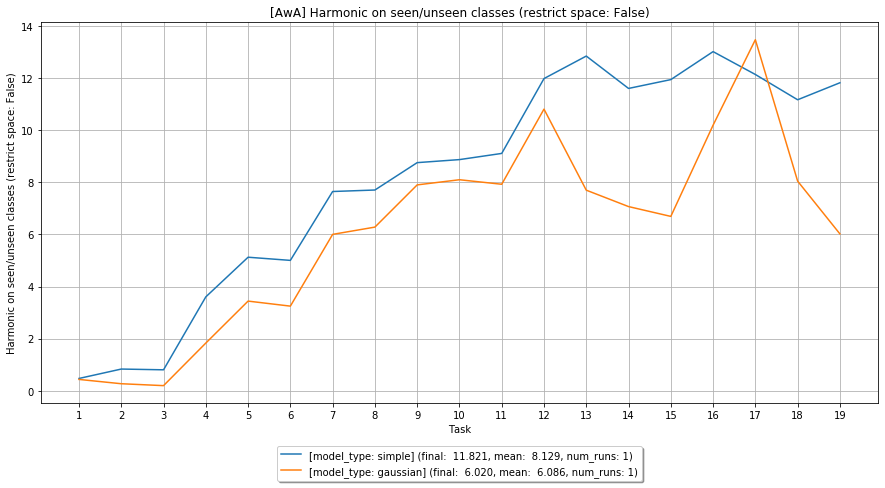

In [16]:
plot_harmonics(methods)

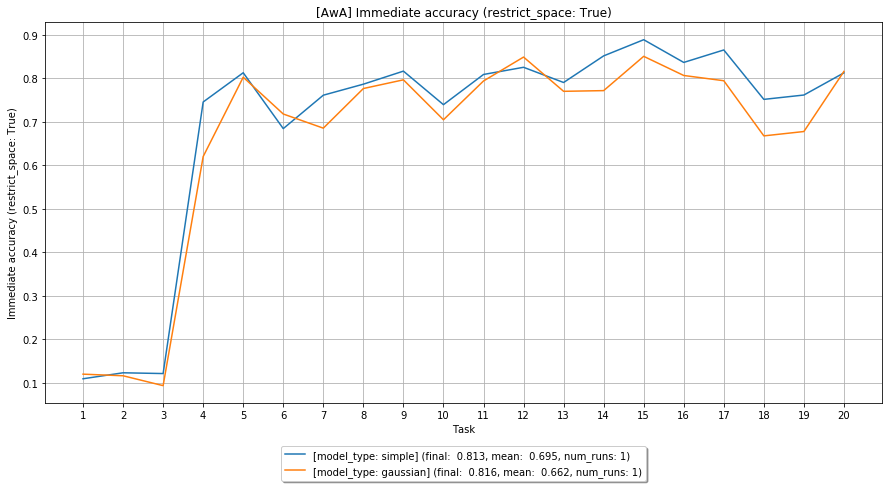

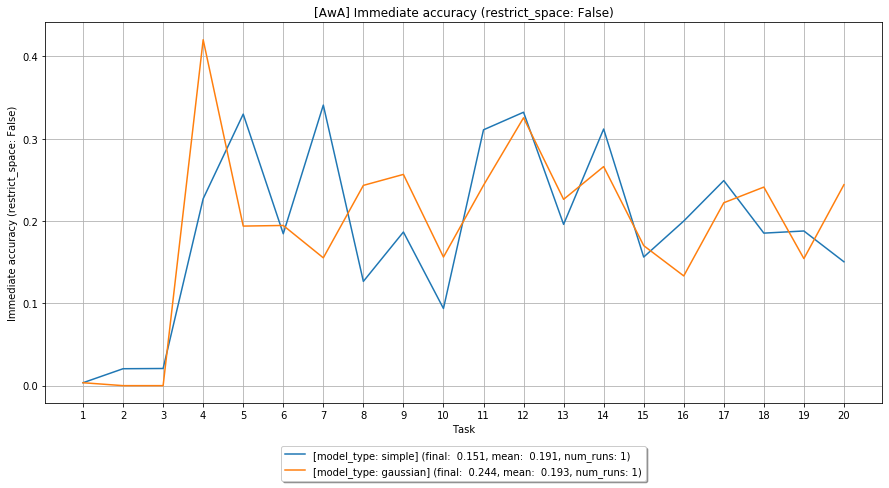

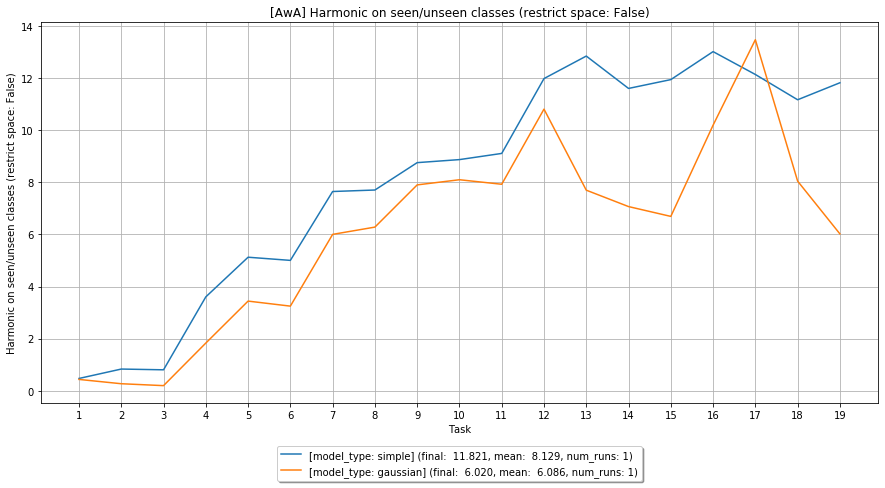

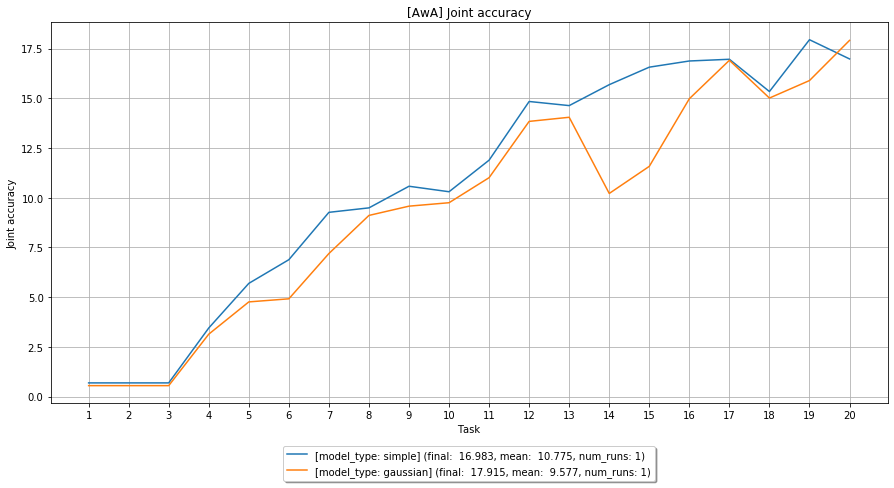

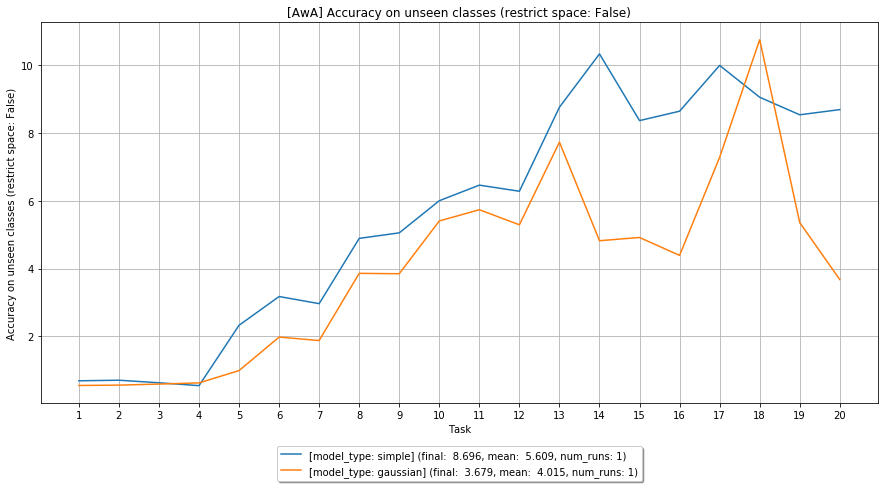

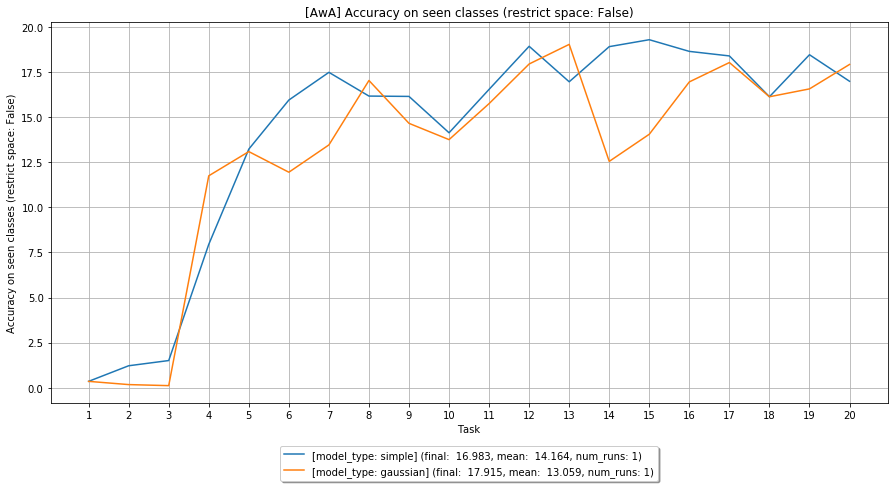

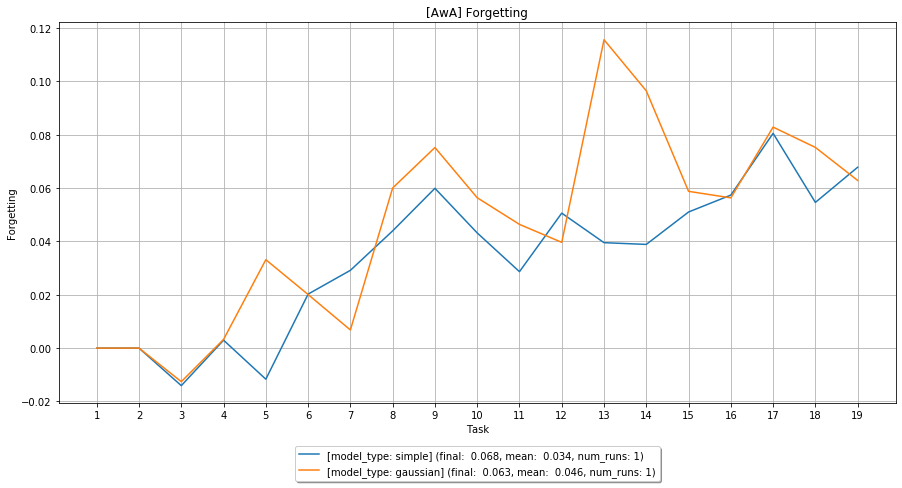

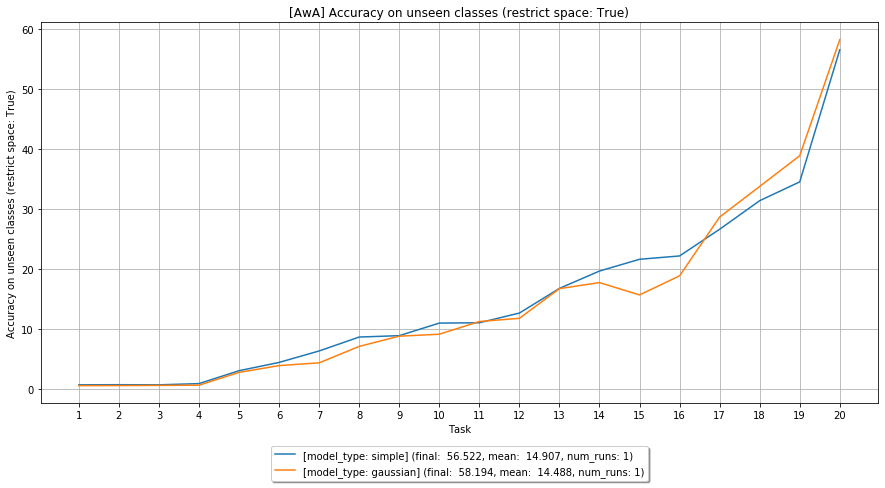

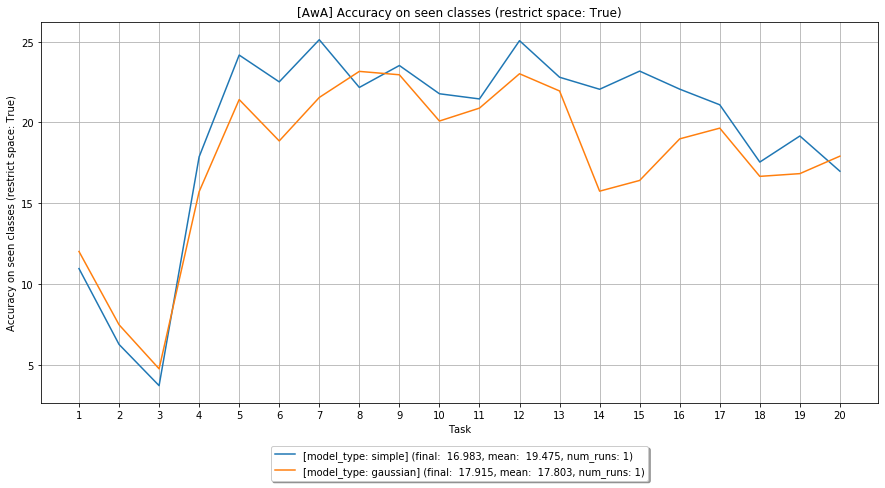

In [17]:
plot_immediate_accs(methods, True)
plot_immediate_accs(methods, False)
plot_harmonics(methods)
#plot_ausucs(methods)
plot_joint(methods)
plot_unseen_acc(methods)
plot_seen_acc(methods)
plot_forgetting(methods)
plot_unseen_acc(methods, True)
plot_seen_acc(methods, True)

  0%|          | 0/4 [00:00<?, ?it/s]

{'hp.optim.groups.head.lr': 0.01, 'hp.head.deep.after_fuse_transform.identity_init': True}
{'hp.optim.groups.head.lr': 0.01, 'hp.head.deep.after_fuse_transform.identity_init': None}
{'hp.optim.groups.head.lr': 0.005, 'hp.head.deep.after_fuse_transform.identity_init': True}
{'hp.optim.groups.head.lr': 0.005, 'hp.head.deep.after_fuse_transform.identity_init': None}


 50%|█████     | 2/4 [00:06<00:06,  3.25s/it]


KeyboardInterrupt: 

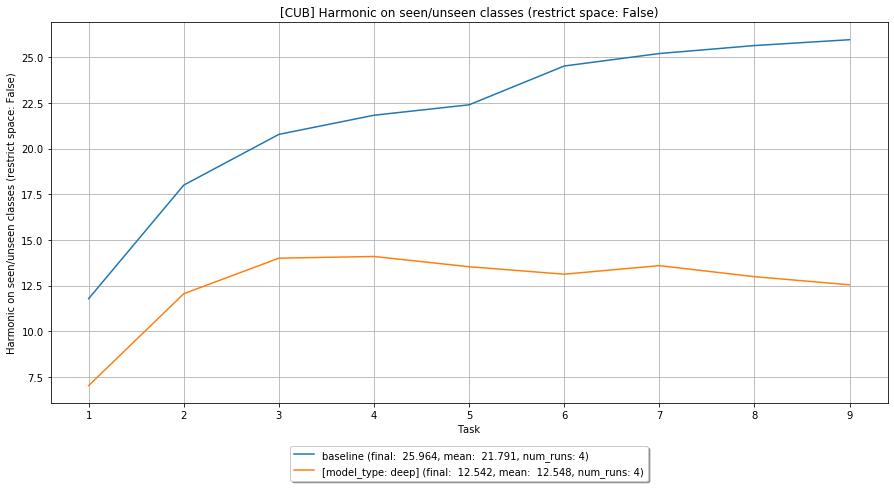

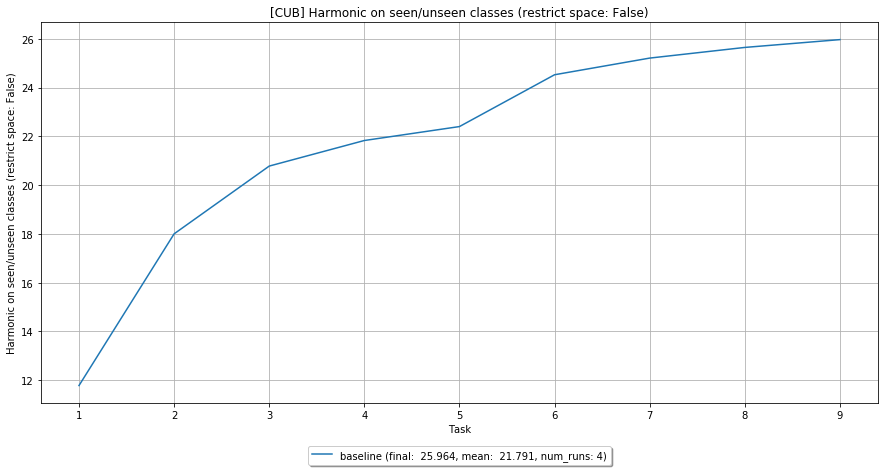

In [91]:
from itertools import product

separators = ['hp.optim.groups.head.lr', 'hp.head.deep.after_fuse_transform.identity_init']
unique_sep_values = [list(set([cs[0].get(s) for _, cs in configs.items()])) for s in separators]
group_values = list(product(*unique_sep_values))
groups = [{k:v for k,v in zip(separators, g)} for g in group_values]
#groups = [g for g in groups if g['hp.head.after_fuse_transform_layers'] != (512,)]
for g in groups: print(g)

baseline_group = {'hp.diagonal_cov_reg.batch_size': None}

for group in tqdm(groups):
    methods = list(get_exps_for_a_group(exps, configs, group).keys())
    methods = list(get_exps_for_a_group(exps, configs, baseline_group).keys()) + methods
    
    plot_harmonics(methods)
    #plot_ausucs(methods)
    #plot_joint(methods)
    #plot_unseen_acc(methods)
    #plot_seen_acc(methods)
    #plot_forgetting(methods)
    #plot_unseen_acc(methods, title=title, True)
    #plot_seen_acc(methods, title=title, True)

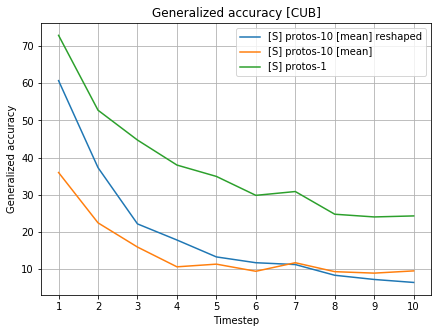

In [114]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(7, 5))
plt.title(f'Generalized accuracy [{dataset}]')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
#     if '(1/4)' in method:
#         kwargs = {"marker": "*"}
#     elif '(1/2)' in method:
#         kwargs = {"marker": ".", 'markersize': 7}
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    if 'no' in method:
        kwargs = {**kwargs, **{'linestyle': '-.'}}
    #plt.plot(tasks, values_avg * 100, label=fr'[S] {method} (final: {values_avg[-1] * 100: .3f})', color=colors[i % len(colors)], **kwargs)
    plt.plot(tasks, values_avg * 100, label=fr'[S] {method}', color=colors[i % len(colors)], **kwargs)

plt.legend()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Timestep')
plt.ylabel('Generalized accuracy')
plt.xticks(tasks)
plt.grid()

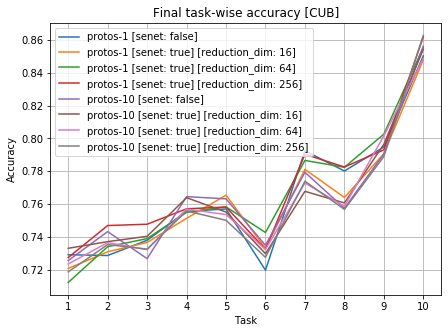

In [60]:
plt.figure(figsize=(7, 5))
plt.title(f'Final task-wise accuracy [{dataset}]')

for method in methods:
    values = [[compute_acc_for_classes(l[-1], t, cs) for cs in c] for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    #plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})', **kwargs)
    plt.plot(tasks, values_avg, label=f'{method}', **kwargs)

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()
# plt.savefig(f'../plots/{dataset.lower()}-final-accs.pdf')

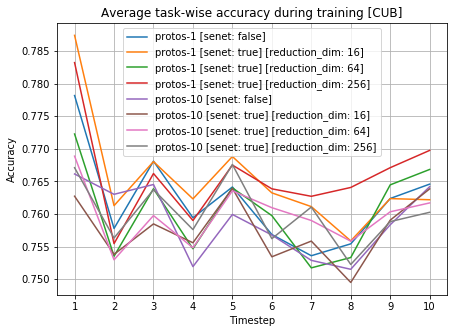

In [61]:
plt.figure(figsize=(7, 5))
plt.title(f'Average task-wise accuracy during training [{dataset}]')

for method in methods:
    values = [compute_average_taskwise_accucy(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
        
    #plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})', **kwargs)
    plt.plot(tasks, values_avg, label=f'{method}')

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()
# plt.savefig(f'../plots/{dataset.lower()}-average-acc.pdf')

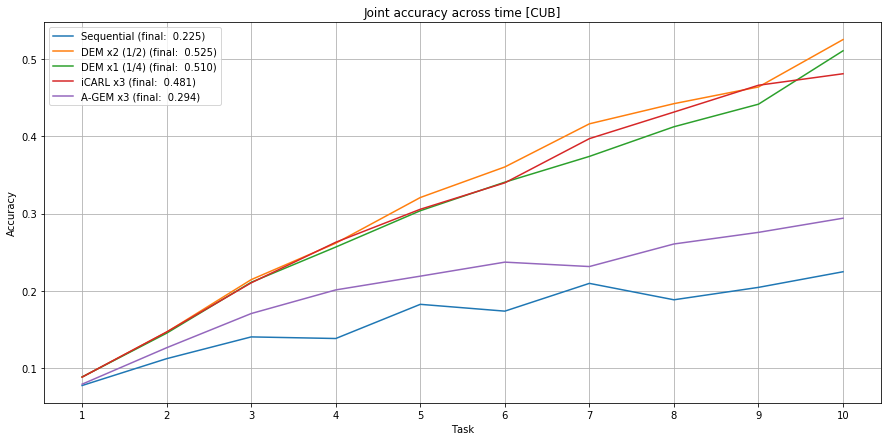

In [91]:
plt.figure(figsize=(15, 7))
plt.title(f'Joint accuracy across time [{dataset}]')

for method in methods:
    values = [(l[1:].argmax(axis=2) == t.reshape(1, -1)).mean(1) for l, t in zip(logits_histories[method], targets[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})')

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

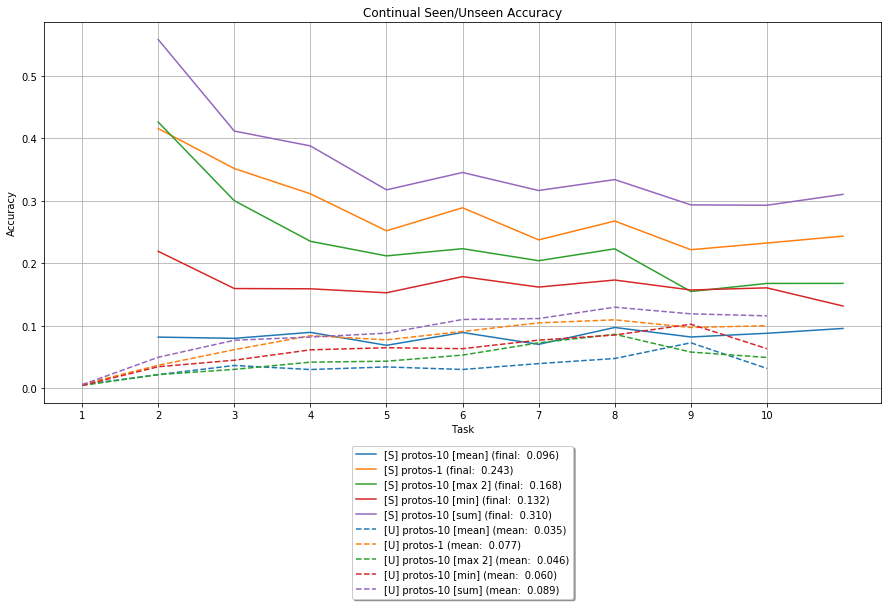

In [119]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 7))
plt.title('Continual Seen/Unseen Accuracy')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=False) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks + 1, values_avg, label=f'[S] {method} (final: {values_avg[-1]: .3f})', color=colors[i % len(colors)])
    #plt.plot(tasks, values_avg, label=f'[S] {method} (mean: {values_avg.mean(): .3f})')

for i, method in enumerate(methods):
    values = [compute_unseen_classes_acc_history(l, t, c, restrict_space=False) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, '--', label=f'[U] {method} (mean: {values_avg.mean(): .3f})', color=colors[i % len(colors)])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

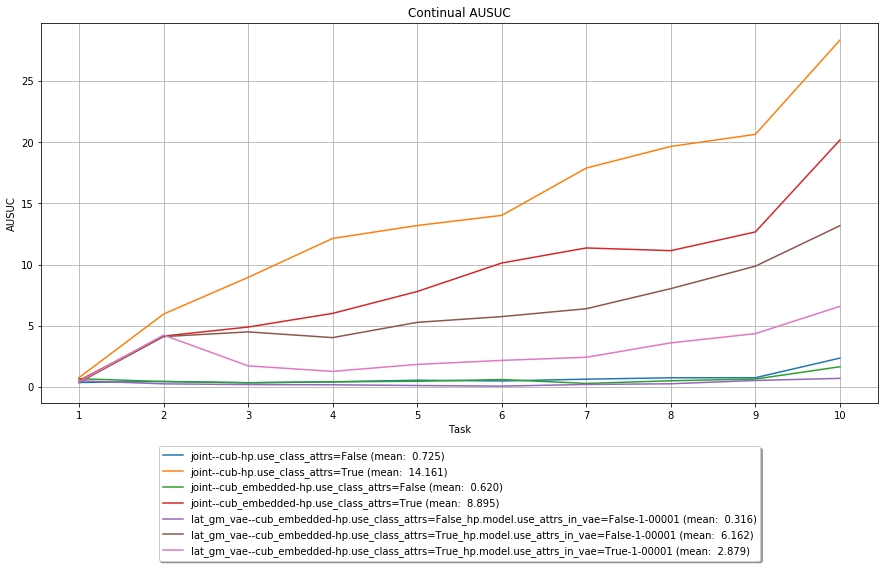

In [5]:
plt.figure(figsize=(15, 7))
plt.title('Continual AUSUC')

for method in methods:
    values = [compute_joined_ausuc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('AUSUC')
plt.xticks(tasks)
plt.grid()

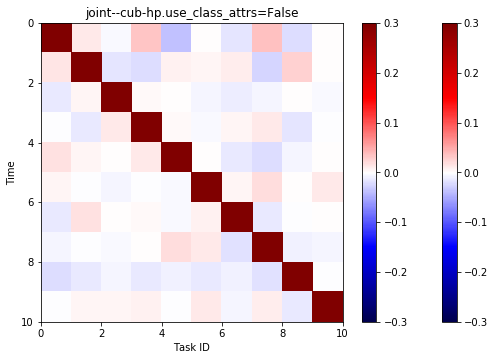

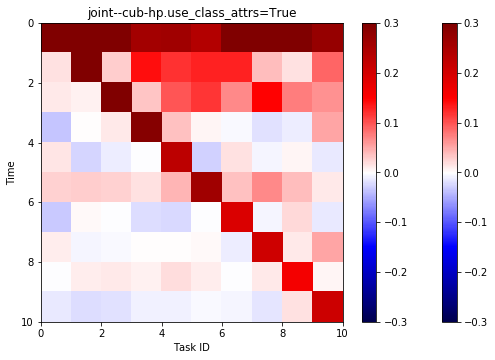

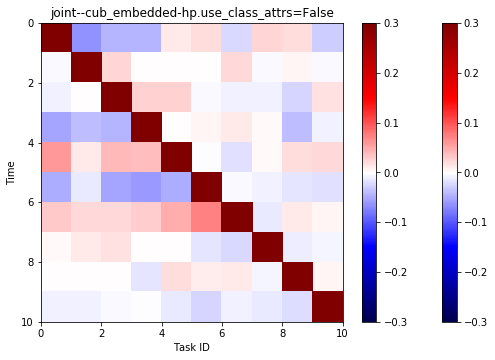

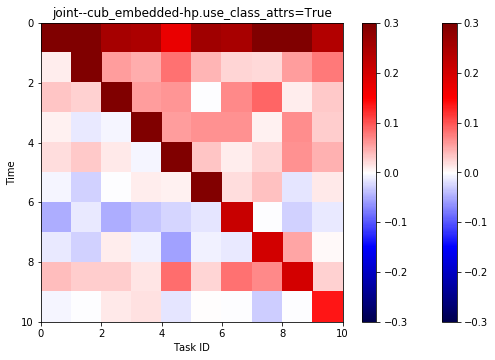

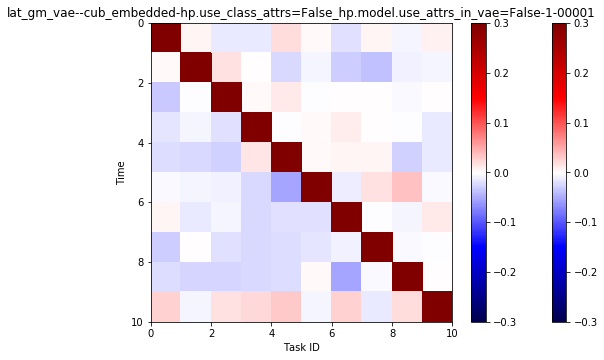

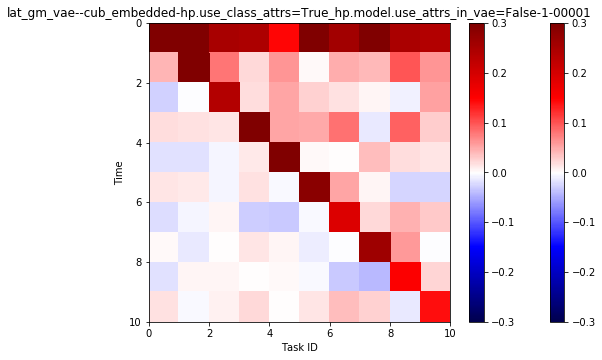

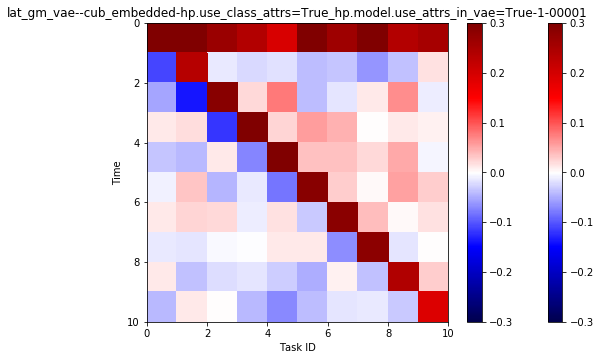

In [8]:
from tqdm import tqdm

def plot_task_transfer_matrix(values, title: str=''):
    # https://stackoverflow.com/questions/35727374/creating-a-matplotlib-heatmap-with-two-different-coloured-data-sets

    mask_red = np.triu(np.ones_like(values), k=1).astype(bool)
    mask_blue = np.tril(np.ones_like(values), k=0).astype(bool)

    values_red = np.ma.masked_where(~mask_red, values)
    values_blue = np.ma.masked_where(~mask_blue, values)

    # # Make a side-by-side plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    redmesh = ax.pcolormesh(values_red, cmap='seismic', vmin=-0.3, vmax=0.3)
    bluemesh = ax.pcolormesh(values_blue, cmap='seismic', vmin=-0.3, vmax=0.3)
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Task ID')
    plt.ylabel('Time')

    # Add dual colorbars
    fig.subplots_adjust(bottom=0.05, right=0.78, top=0.88, wspace=0, hspace=0)
    cbar = fig.colorbar(redmesh)
    cbar = fig.colorbar(bluemesh)
    plt.show()


# plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_acc = [compute_task_transfer_matrix(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_acc_avg = np.array(values_acc).mean(0)
    plot_task_transfer_matrix(values_acc_avg, method)

#     plt.subplot(3, 3, i + 1)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

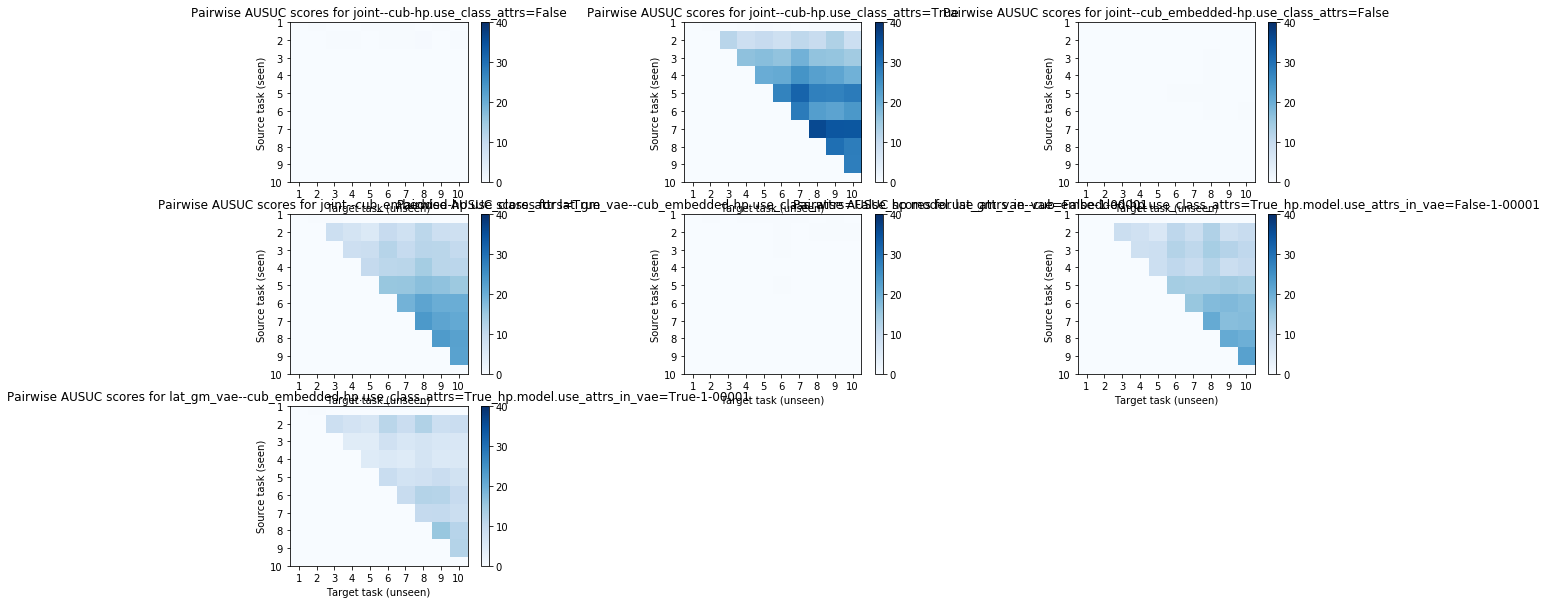

In [9]:
plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]    
    values_ausuc_avg = np.array(values_ausuc).mean(0)
    
    plt.subplot(3, 3, i + 1)
    plt.title(f'Pairwise AUSUC scores for {method}')
    plt.imshow(np.triu(values_ausuc_avg, k=1), cmap='Blues', vmin=0, vmax=40)
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.clim(0, 100)
    plt.ylabel('Source task (seen)')
    plt.xlabel('Target task (unseen)')
    plt.xticks(tasks - 1, tasks);
    plt.yticks(tasks - 1, tasks);

In [37]:
# for method in methods:
#     values_acc = [compute_individual_accs_matrix(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
#     values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
#     values_acc_avg = np.array(values_acc).mean(0)
#     values_ausuc_avg = np.array(values_ausuc).mean(0)

#     plt.figure(figsize=(15, 7))
    
#     plt.subplot(121)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 1)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

#     plt.subplot(122)
#     plt.title(f'Pairwise AUSUC scores for [{method}]')
#     plt.imshow(np.triu(values_ausuc_avg), cmap='Blues', vmin=0, vmax=70)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 100)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);